In [1]:
# !pip3 install neo4j-driver
# !pip3 install graphdatascience
# %matplotlib inline

import json
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from neo4j import GraphDatabase, basic_auth
from graphdatascience import GraphDataScience as gds
# from neo4j import GraphDataScience as gds

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# A wrapper class to manage connection
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver( self.__uri, auth=basic_auth(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [3]:
# Actually create a connection. Copy uri (with bolt port), username and passwords from your own sandbox instance
conn = Neo4jConnection(uri="neo4j+s://d409002d.databases.neo4j.io", user="neo4j", pwd="QZ9vR5sTj4A72_Xf4ZZVdPfmZdxRQL0uX3vLAUy-5Wc")

In [4]:
# clear data
# DETACH will remove add edges as well
query_string = '''
MATCH (c:Character) 
DETACH DELETE c;
'''
conn.query(query_string)

# read characters from season1 of GOT and add as Character nodes 
query_string = '''
WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s1-nodes.csv" AS uri
LOAD CSV WITH HEADERS FROM uri AS row 
MERGE (c:Character {id:row.Id})
SET c.name = row.Label
'''
conn.query(query_string)

# read character interactions from season1 of GOT and add as edges
query_string = '''
WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s1-edges.csv" AS uri
LOAD CSV WITH HEADERS FROM uri AS row
MATCH (source:Character {id: row.Source})
MATCH (target:Character {id: row.Target})
MERGE (source)-[:SEASON1 {weight: toInteger(row.Weight)}]-(target)
'''
conn.query(query_string)





[]

## Question 1 & 2

### Code for reading even season 2-8

In [5]:
for i in range(2,9):
    query_string = f'''
    WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s{i}-nodes.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row 
    MERGE (c:Character {{id:row.Id}})
    SET c.name = row.Label
    '''
    conn.query(query_string)
    
    query_string = f'''
    WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s{i}-edges.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row
    MATCH (source:Character {{id: row.Source}})
    MATCH (target:Character {{id: row.Target}})
    MERGE (source)-[:SEASON{i} {{weight: toInteger(row.Weight)}}]-(target)
    '''
    conn.query(query_string)
    


## Question 3

### Computing degree of nodes for each season separately

In [7]:
# See the degrees of nodes
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON1]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

    c.name  inDegree
0  Catelyn        29
1     Arya        28
2   Cersei        23
3      Ned        23
4     Bran        18


In [8]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON2]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

    c.name  inDegree
0   Cersei        28
1     Arya        25
2  Joffrey        23
3  Catelyn        19
4    Bronn        15


In [9]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON3]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

    c.name  inDegree
0   Cersei        18
1     Bran        17
2  Catelyn        16
3     Arya        15
4    Bronn        14


In [10]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON4]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

    c.name  inDegree
0   Cersei        28
1  Joffrey        26
2     Arya        24
3      Jon        20
4    Jaime        19


In [11]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON5]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

    c.name  inDegree
0   Cersei        29
1    Petyr        20
2      Jon        18
3  Alliser        11
4     Arya        11


In [12]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON6]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

     c.name  inDegree
0    Cersei        24
1       Jon        21
2     Davos        20
3      Arya        17
4  Daenerys        16


In [13]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON7]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

     c.name  inDegree
0  Daenerys        28
1    Cersei        26
2       Jon        24
3   Brienne        22
4     Davos        22


In [14]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON8]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(5))

     c.name  inDegree
0      Arya        38
1  Daenerys        32
2   Brienne        30
3     Davos        30
4      Bran        29


### Computing combined degree of nodes for all seasons

In [58]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, 
        SIZE([(c)-[:SEASON1]->() | 1]) AS season1_degree,
        SIZE([(c)-[:SEASON2]->() | 1]) AS season2_degree,
        SIZE([(c)-[:SEASON3]->() | 1]) AS season3_degree,
        SIZE([(c)-[:SEASON4]->() | 1]) AS season4_degree,
        SIZE([(c)-[:SEASON5]->() | 1]) AS season5_degree,
        SIZE([(c)-[:SEASON6]->() | 1]) AS season6_degree,
        SIZE([(c)-[:SEASON7]->() | 1]) AS season7_degree,
        SIZE([(c)-[:SEASON8]->() | 1]) AS season8_degree,
        (SIZE([(c)-[:SEASON1]->() | 1]) + 
        SIZE([(c)-[:SEASON2]->() | 1]) +
        SIZE([(c)-[:SEASON3]->() | 1]) +
        SIZE([(c)-[:SEASON4]->() | 1]) +
        SIZE([(c)-[:SEASON5]->() | 1]) +
        SIZE([(c)-[:SEASON6]->() | 1]) +
        SIZE([(c)-[:SEASON7]->() | 1]) +
        SIZE([(c)-[:SEASON8]->() | 1])) AS combinedDegree 
ORDER BY combinedDegree DESC 
'''

top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(30))

       c.name  season1_degree  season2_degree  season3_degree  season4_degree  \
0      Cersei              23              28              18              28   
1        Arya              28              25              15              24   
2    Daenerys              17              13              10              14   
3         Jon              14               6              12              20   
4        Bran              18              13              17              15   
5       Jaime              16              12              13              19   
6       Davos               0              11               8              12   
7     Brienne               0              13               5              15   
8     Joffrey              18              23              14              26   
9       Bronn              12              15              14              14   
10    Catelyn              29              19              16              11   
11      Petyr              1

## Question 4

In [41]:
# See the degrees of nodes
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[:SEASON1]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(10))

     c.name  inDegree
0   Catelyn        29
1      Arya        28
2    Cersei        23
3       Ned        23
4      Bran        18
5   Joffrey        18
6  Daenerys        17
7     Jaime        16
8     Petyr        15
9       Jon        14


In [42]:
top_cat_df = top_cat_df.rename(columns={'inDegree': 'SEASON1 inDegree'})

In [43]:
print(top_cat_df.head(10))

     c.name  SEASON1 inDegree
0   Catelyn                29
1      Arya                28
2    Cersei                23
3       Ned                23
4      Bran                18
5   Joffrey                18
6  Daenerys                17
7     Jaime                16
8     Petyr                15
9       Jon                14


In [6]:
query_string = '''
MATCH (c:Character) 
RETURN c.name, 
        SIZE([(c)-[:SEASON1]->() | 1]) AS season1_degree,
        SIZE([(c)-[:SEASON2]->() | 1]) AS season2_degree,
        SIZE([(c)-[:SEASON3]->() | 1]) AS season3_degree,
        SIZE([(c)-[:SEASON4]->() | 1]) AS season4_degree,
        SIZE([(c)-[:SEASON5]->() | 1]) AS season5_degree,
        SIZE([(c)-[:SEASON6]->() | 1]) AS season6_degree,
        SIZE([(c)-[:SEASON7]->() | 1]) AS season7_degree,
        SIZE([(c)-[:SEASON8]->() | 1]) AS season8_degree,
        (SIZE([(c)-[:SEASON1]->() | 1]) + 
        SIZE([(c)-[:SEASON2]->() | 1]) +
        SIZE([(c)-[:SEASON3]->() | 1]) +
        SIZE([(c)-[:SEASON4]->() | 1]) +
        SIZE([(c)-[:SEASON5]->() | 1]) +
        SIZE([(c)-[:SEASON6]->() | 1]) +
        SIZE([(c)-[:SEASON7]->() | 1]) +
        SIZE([(c)-[:SEASON8]->() | 1])) AS combinedDegree 
ORDER BY season1_degree DESC 
'''

result = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

print(result)

top_cat_10_df = result.head(10)

            c.name  season1_degree  season2_degree  season3_degree  \
0          Catelyn              29              19              16   
1             Arya              28              25              15   
2           Cersei              23              28              18   
3              Ned              23              10               7   
4             Bran              18              13              17   
..             ...             ...             ...             ...   
402          Varly               0               0               0   
403        Viserys               0               0               0   
404         Walder               0               0               0   
405           Will               0               0               0   
406  Wine Merchant               0               0               0   

     season4_degree  season5_degree  season6_degree  season7_degree  \
0                11               4               5               3   
1                

     c.name  season1_degree  season2_degree  season3_degree  season4_degree  \
0   Catelyn              29              19              16              11   
1      Arya              28              25              15              24   
2    Cersei              23              28              18              28   
3       Ned              23              10               7               5   
4      Bran              18              13              17              15   
5   Joffrey              18              23              14              26   
6  Daenerys              17              13              10              14   
7     Jaime              16              12              13              19   
8     Petyr              15              13               9               8   
9       Jon              14               6              12              20   

   season5_degree  season6_degree  season7_degree  season8_degree  \
0               4               5               3            

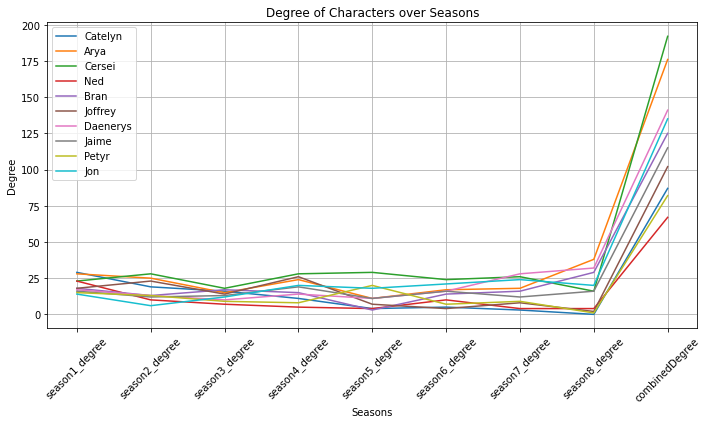

In [15]:
import numpy as np

print(top_cat_10_df)
# Convert DataFrame columns to numpy array
columns_array = np.array(top_cat_10_df.columns[1:])
plt.figure(figsize=(10, 6))
for i in range(len(top_cat_10_df)):
    # Convert DataFrame row to numpy array
    row_array = np.array(top_cat_10_df.iloc[i, 1:])
    plt.plot(columns_array, row_array, label=top_cat_10_df.iloc[i, 0])

    

plt.xlabel('Seasons')
plt.ylabel('Degree')
plt.title('Degree of Characters over Seasons')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Question 5

In [154]:
for i in range(1, 9):
    query_string = f'''
    WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s{i}-edges.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row
    MERGE (source:Character {{name: row.Source}})
    MERGE (target:Character {{name: row.Target}})
    MERGE (source)-[rel:INTERACTS]->(target)
    SET rel.Weight = toInteger(row.Weight)
    RETURN source.name AS Source, target.name AS Target, rel.Weight AS Weight
    ORDER BY rel.Weight DESC
    LIMIT 1
    '''
    result_max_interact = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
    print(result_max_interact.head(1))

  Source  Target  Weight
0    NED  ROBERT     192
   Source  Target  Weight
0  CERSEI  TYRION     177
  Source   Target  Weight
0    JON  YGRITTE     159
  Source Target  Weight
0   ARYA  HOUND     162
  Source Target  Weight
0   ARYA  JAQEN     148
  Source Target  Weight
0    JON  SANSA     151
     Source  Target  Weight
0  DAENERYS  TYRION     179
     Source Target  Weight
0  DAENERYS    JON     194


## Question 6

### Both way interactions

In [175]:
query_string = '''
MATCH (c:Character)-[R]-(other:Character)
WITH c, COUNT(DISTINCT other) AS numDistinctInteractions
ORDER BY numDistinctInteractions DESC
LIMIT 10
RETURN c.name AS Character, numDistinctInteractions AS NumDistinctInteractions
'''


[dict(_) for _ in conn.query(query_string)]



[{'Character': 'Tyrion', 'NumDistinctInteractions': 128},
 {'Character': 'Jon', 'NumDistinctInteractions': 105},
 {'Character': 'Sansa', 'NumDistinctInteractions': 101},
 {'Character': 'Arya', 'NumDistinctInteractions': 97},
 {'Character': 'Daenerys', 'NumDistinctInteractions': 93},
 {'Character': 'Jaime', 'NumDistinctInteractions': 90},
 {'Character': 'Cersei', 'NumDistinctInteractions': 86},
 {'Character': 'Davos', 'NumDistinctInteractions': 78},
 {'Character': 'Ned', 'NumDistinctInteractions': 78},
 {'Character': 'Sam', 'NumDistinctInteractions': 78}]

### One way interactions

In [176]:
query_string = '''
MATCH (c:Character)-[R]->(other:Character)
WITH c, COUNT(DISTINCT other) AS numDistinctInteractions
ORDER BY numDistinctInteractions DESC
LIMIT 10
RETURN c.name AS Character, numDistinctInteractions AS NumDistinctInteractions
'''


[dict(_) for _ in conn.query(query_string)]

[{'Character': 'Arya', 'NumDistinctInteractions': 93},
 {'Character': 'Daenerys', 'NumDistinctInteractions': 80},
 {'Character': 'Cersei', 'NumDistinctInteractions': 73},
 {'Character': 'Bran', 'NumDistinctInteractions': 67},
 {'Character': 'Jon', 'NumDistinctInteractions': 66},
 {'Character': 'Davos', 'NumDistinctInteractions': 63},
 {'Character': 'Bronn', 'NumDistinctInteractions': 61},
 {'Character': 'Jaime', 'NumDistinctInteractions': 57},
 {'Character': 'Brienne', 'NumDistinctInteractions': 54},
 {'Character': 'Sandor', 'NumDistinctInteractions': 47}]

In [143]:
#Create a projecttion of the season 1 subgraph
query_string = '''
CALL gds.graph.project.cypher(
    'season1_graph',
    'MATCH (n) RETURN id(n) AS id',
    'MATCH (n)-[e:SEASON1]-(m) RETURN id(n) AS source, e.weight AS weight, id(m) AS target'
)
'''
conn.query(query_string)

Query failed: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `gds.graph.project.cypher` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}


In [138]:
# Compute pagerank of the season 1 subgraph
query_string = '''
CALL gds.pageRank.stream('season1_graph', {
  maxIterations: 100,
  dampingFactor: 0.85,
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS id,      gds.util.asNode(nodeId).name as name, score as full_pagerank
ORDER BY full_pagerank DESC
'''
conn.query(query_string)

Query failed: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `gds.pageRank.stream` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}


In [ ]:
# Detect communities from the season 1 subgraph
query_string = '''
CALL gds.louvain.write('season1_graph', 
    {relationshipWeightProperty: 'weight', 
     writeProperty: 'full_community_id'
})
'''
conn.query(query_string)